In [1]:
import pandas as pd
import wandb
import pandas as pd
import ast
import glob
import numpy as np

from datetime import date
from collections import defaultdict

today = date.today()
api = wandb.Api()

# # Find all csv files in the current directory
csv_files = glob.glob("*.csv")
# # Collect all the names of the csv files without the extension
csv_names = [csv_file[:-4] for csv_file in csv_files]
project_name = "topobenchmark_0503"  #'best_results_edhnn'
user = "telyatnikov_sap"

if project_name not in csv_names:
    runs = api.runs(f"{user}/{project_name}")

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k, v in run.config.items() if not k.startswith("_")}
        )

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame(
        {"summary": summary_list, "config": config_list, "name": name_list}
    )

    runs_df.to_csv(f"{project_name}.csv")
else:
    runs_df = pd.read_csv(f"{project_name}.csv", index_col=0)

    for row in runs_df.iloc:
        row["summary"] = ast.literal_eval(row["summary"])
        row["config"] = ast.literal_eval(row["config"])


for row in runs_df.iloc:
    row["summary"].update(row["config"])

lst = [i["summary"] for i in runs_df.iloc]
df = pd.DataFrame.from_dict(lst)

df_init = df.copy()

# Get average epoch run time
df["epoch_run_time"] = df["_runtime"] / df["epoch"]

In [2]:
def normalize_column(df, column_to_normalize):
    # Use json_normalize to flatten the nested dictionaries into separate columns
    flattened_df = pd.json_normalize(df[column_to_normalize])
    # Rename columns to include 'nested_column' prefix
    flattened_df.columns = [
        f"{column_to_normalize}.{col}" for col in flattened_df.columns
    ]
    # Concatenate the flattened DataFrame with the original DataFrame
    result_df = pd.concat([df, flattened_df], axis=1)
    # Get new columns names
    new_columns = flattened_df.columns
    # Drop the original nested column if needed
    result_df.drop(column_to_normalize, axis=1, inplace=True)
    return result_df, new_columns


# Config columns to normalize
columns_to_normalize = ["model", "dataset", "callbacks"]

# Keep track of config columns added
config_columns = []
for column in columns_to_normalize:
    df, columns = normalize_column(df, column)
    config_columns.extend(columns)

In [3]:
# Remove columns that are not needed (we shouldn't vary them or their variation is not interesting)
remove_col = [
    "dataset.transforms.data_manipulations.selected_fields",
    "callbacks.model_checkpoint.dirpath",
]
df = df.drop(remove_col, axis=1)

# Ensure that removed columns are not present in config_columns
config_columns = [col for col in config_columns if col != remove_col]

In [4]:
print(
    f"Number of rows with model.backbone._target_ = nan is {sum(df['model.backbone._target_'].isna())}"
)
# Drop na values if there are
df = df.dropna(subset=["model.backbone._target_"])
# Reset index
df = df.reset_index(drop=True)

# Drop rows that 'callbacks.early_stopping.monitor' isna
print(
    f"Number of rows with callbacks.early_stopping.monitor = nan is {sum(df['callbacks.early_stopping.monitor'].isna())}"
)
print("Because of SCCN and CWN false runs there were 96 such runs on 13/03/24")
df = df.dropna(subset=["callbacks.early_stopping.monitor"])
# Reset index
df = df.reset_index(drop=True)


# Get correct names for the models
df["model.backbone._target_"] = df["model.backbone._target_"].apply(
    lambda x: x.split(".")[-1]
)

Number of rows with model.backbone._target_ = nan is 3
Number of rows with callbacks.early_stopping.monitor = nan is 36
Because of SCCN and CWN false runs there were 96 such runs on 13/03/24


In [5]:
# Identify unique models in DataFrame
unique_models = df["model.backbone._target_"].unique()

# Identify unique datasets in DataFrame
unique_datasets = df["dataset.parameters.data_name"].unique()


collected_results = defaultdict(dict)
# Got over each dataset and model and find the best result
for dataset in unique_datasets:
    for model in unique_models:
        # Get the subset of the DataFrame for the current dataset and model
        subset = df[
            (df["dataset.parameters.data_name"] == dataset)
            & (df["model.backbone._target_"] == model)
        ]
        subset["Model"] = model

        if subset.empty:
            print(f"---------")
            print(f"No results for {model} on {dataset}")
            print(f"---------")
            continue

        def get_metric(df):
            metric_ = df["callbacks.early_stopping.monitor"].unique()
            assert len(metric_) == 1, "There should be only one metric to optimize"
            metric = metric_[0]
            return metric.split("/")[-1]

        # Cols to get statistics later
        # TODO: log maximum validation value for optimized metric
        performance_cols = [f"test/{get_metric(subset)}"]

        # Get the unique values for each config column
        unique_colums_values = {}
        for col in config_columns:
            try:
                unique_colums_values[col] = subset[col].unique()
            except:
                print(f"Attention the columns: {col}, has issues with unique values")

        # Keep only those keys that have more than one unique value
        unique_colums_values = {
            k: v for k, v in unique_colums_values.items() if len(v) > 1
        }

        # Print the unique values for each config column
        print(f"---------")
        print(f"Unique values for each config column for {model} on {dataset}:")
        for col, unique in unique_colums_values.items():
            print(f"{col}: {unique}")
            print()
        print(f"---------")

        # Check if "special colums" are not in unique_colums_values
        # For example dataset.parameters.data_seed should not be in aggregation columns
        # If it is, then we should remove it from the list
        special_columns = ["dataset.parameters.data_seed"]

        for col in special_columns:
            if col in unique_colums_values:
                unique_colums_values.pop(col)

        # Obtain the aggregation columns
        aggregation_columns = ["Model"] + list(unique_colums_values.keys())

        # Aggregate the subset by the aggregation columns and get the best result for each group
        aggregated = subset.groupby(aggregation_columns).agg(
            {col: ["mean", "std"] for col in performance_cols}
        )

        # Go from MultiIndex to Index
        aggregated = aggregated.reset_index()

        assert (
            len(subset["callbacks.early_stopping.mode"].unique()) == 1
        ), "There should be only one mode for early stopping"
        # Identify the mode of the early stopping mode

        if subset["callbacks.early_stopping.mode"].unique()[0] == "max":
            ascending = False
            final_best_ = aggregated.sort_values(
                by=(f"test/{get_metric(subset)}", "mean"), ascending=ascending
            ).head(1)
            final_best_ = (final_best_ * 100).round(2)
        else:
            ascending = True
            final_best_ = aggregated.sort_values(
                by=(f"test/{get_metric(subset)}", "mean"), ascending=ascending
            ).head(1)

        collected_results[dataset][model] = {
            "mean": final_best_[(f"test/{get_metric(subset)}", "mean")].values[0],
            "std": final_best_[(f"test/{get_metric(subset)}", "std")].values[0],
        }

        # # Get the index of the best result
        # best_result_index = subset['summary.val_acc'].idxmax()
        # # Get the best result
        # best_result = subset.loc[best_result_index]
        # # Print the best result
        # print(f"Best result for {model} on {dataset}:")
        # print(best_result)
        # print()

/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Model"] = model
/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Model"] = model
/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Attention the columns: model.feature_encoder.in_channels, has issues with unique values
Attention the columns: dataset.transforms.data_manipulations.selected_fields, has issues with unique values
Attention the columns: callbacks.model_checkpoint.dirpath, has issues with unique values
---------
Unique values for each config column for GCN on REDDIT-BINARY:
model.readout.in_channels: [256. 128.  64.]

model.backbone.dropout: [0.25 0.   0.5 ]

model.backbone.num_layers: [2. 1. 4. 3.]

model.backbone.hidden_channels: [256. 128.  64.]

dataset.parameters.data_seed: [3. 0. 5.]

dataset.parameters.batch_size: [256. 128.]

dataset.parameters.monitor_metric: ['accuracy' nan]

---------
---------
No results for SCCNN on REDDIT-BINARY
---------
---------
No results for CWN on REDDIT-BINARY
---------
---------
No results for SCCN on REDDIT-BINARY
---------
Attention the columns: dataset.transforms.data_manipulations.selected_fields, has issues with unique values
Attention the columns: callbacks.mo

/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Model"] = model
/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Model"] = model
/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Attention the columns: callbacks.model_checkpoint.dirpath, has issues with unique values
---------
Unique values for each config column for AllSet on PROTEINS:
model.readout.in_channels: [128.  64.  32.  16.]

model.backbone.in_channels: [128.  64.  32.  16.]

model.backbone.hidden_channels: [128.  64.  32.  16.]

model.optimizer.lr: [0.001 0.01 ]

model.feature_encoder.out_channels: [128.  64.  32.  16.]

model.backbone.n_layers: [4. 3. 2. 1.]

model.backbone.layer_dropout: [0.5  0.25 0.  ]

model.backbone.mlp_num_layers: [2. 1.]

dataset.parameters.data_seed: [5. 3. 0.]

dataset.parameters.batch_size: [256. 128.]

---------
Attention the columns: dataset.transforms.data_manipulations.selected_fields, has issues with unique values
Attention the columns: callbacks.model_checkpoint.dirpath, has issues with unique values
---------
Unique values for each config column for UniGCNII on PROTEINS:
model.readout.in_channels: [128.  64.  32.  16.]

model.backbone.in_channels: [128.  64.  32.  1

/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Model"] = model
/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Model"] = model
/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Attention the columns: dataset.transforms.data_manipulations.selected_fields, has issues with unique values
Attention the columns: callbacks.model_checkpoint.dirpath, has issues with unique values
---------
Unique values for each config column for EDGNN on citeseer:
model.readout.in_channels: [256. 128.  64.]

model.optimizer.lr: [0.001 0.01 ]

model.feature_encoder.out_channels: [256. 128.  64.]

model.backbone.num_features: [256. 128.  64.]

model.backbone.input_dropout: [0.5  0.25 0.  ]

model.backbone.All_num_layers: [2. 1.]

model.backbone.MLP_num_layers: [2. 1. 0.]

dataset.parameters.data_seed: [5. 3. 0.]

---------
Attention the columns: dataset.transforms.data_manipulations.selected_fields, has issues with unique values
Attention the columns: callbacks.model_checkpoint.dirpath, has issues with unique values
---------
Unique values for each config column for GIN on citeseer:
model.readout.in_channels: [256. 128.  64.]

model.backbone.dropout: [0.5  0.25 0.  ]

model.backbone.nu

/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Model"] = model
/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Model"] = model
/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

---------
No results for UniGCNII on IMDB-BINARY
---------
Attention the columns: dataset.transforms.data_manipulations.selected_fields, has issues with unique values
Attention the columns: callbacks.model_checkpoint.dirpath, has issues with unique values
---------
Unique values for each config column for EDGNN on IMDB-BINARY:
model.readout.in_channels: [128.  64.  32.  16.]

model.optimizer.lr: [0.001 0.01 ]

model.feature_encoder.out_channels: [128.  64.  32.  16.]

model.backbone.num_features: [128.  64.  32.  16.]

model.backbone.input_dropout: [0.5  0.25 0.  ]

model.backbone.All_num_layers: [3. 2. 1.]

model.backbone.MLP_num_layers: [2. 1. 0.]

dataset.parameters.data_seed: [5. 3. 0.]

dataset.parameters.batch_size: [256. 128.]

---------
Attention the columns: dataset.transforms.data_manipulations.selected_fields, has issues with unique values
Attention the columns: callbacks.model_checkpoint.dirpath, has issues with unique values
---------
Unique values for each config column f

/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Model"] = model
/tmp/ipykernel_982784/3855000361.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Model"] = model


In [6]:
# Convert nested dictionary to DataFrame
nested_dict = dict(collected_results)
result_dict = pd.DataFrame.from_dict(
    {
        (i, j): nested_dict[i][j]
        for i in nested_dict.keys()
        for j in nested_dict[i].keys()
    },
    orient="index",
)


result_dict = result_dict.round(2)
result_dict["performance"] = result_dict.apply(
    lambda x: f"{x['mean']} ± {x['std']}", axis=1
)
result_dict = result_dict.drop(["mean", "std"], axis=1)

# Reset multiindex
result_dict = result_dict.reset_index()
# rename columns
result_dict.columns = ["Dataset", "Model", "Performance"]

In [7]:
result_dict.pivot_table(
    index="Model", columns="Dataset", values="Performance", aggfunc="first"
)

Dataset,Cora,IMDB-BINARY,IMDB-MULTI,MUTAG,NCI1,PROTEINS,PubMed,REDDIT-BINARY,ZINC,citeseer
Model,,,,,,,,,,
AllSet,89.05 ± 0.56,80.0 ± 2.65,52.89 ± 2.04,92.59 ± 3.21,80.7 ± 0.85,81.6 ± 4.56,88.12 ± 0.2,75.0 ± 1.41,NaN,75.28 ± 1.83
CWN,88.56 ± 1.95,NaN,NaN,nan ± nan,77.45 ± 1.1,78.73 ± 4.32,87.53 ± 0.5,NaN,0.45 ± nan,75.48 ± 1.76
EDGNN,90.16 ± 0.43,78.33 ± 1.15,53.33 ± 0.67,92.59 ± 3.21,80.05 ± nan,81.61 ± 2.02,90.38 ± 0.47,83.5 ± 0.87,0.44 ± nan,77.38 ± 0.87
GCN,89.85 ± 1.83,NaN,NaN,90.74 ± 3.21,80.37 ± 0.37,79.93 ± 4.68,88.54 ± 0.13,75.67 ± 1.15,NaN,76.38 ± 1.35
GIN,89.79 ± 0.93,78.67 ± 1.53,52.22 ± 1.39,94.44 ± 5.56,81.75 ± 0.84,80.23 ± 5.08,87.54 ± 0.57,86.5 ± 2.78,0.4 ± nan,76.08 ± 1.81
SCCN,89.42 ± 1.19,77.33 ± 4.04,51.11 ± 0.77,94.44 ± 7.86,80.94 ± 1.1,81.42 ± 6.05,89.16 ± 0.28,NaN,0.45 ± nan,76.88 ± 2.08
SCCNN,88.19 ± 1.11,NaN,NaN,90.74 ± 3.21,76.56 ± 1.15,79.93 ± 5.33,88.81 ± 0.41,NaN,0.74 ± nan,75.38 ± 1.5
UniGCNII,90.65 ± 0.85,NaN,NaN,NaN,77.94 ± 1.84,81.13 ± 5.53,89.49 ± 0.16,NaN,NaN,77.48 ± 0.52


# Curl and divergence operators applied to vector field

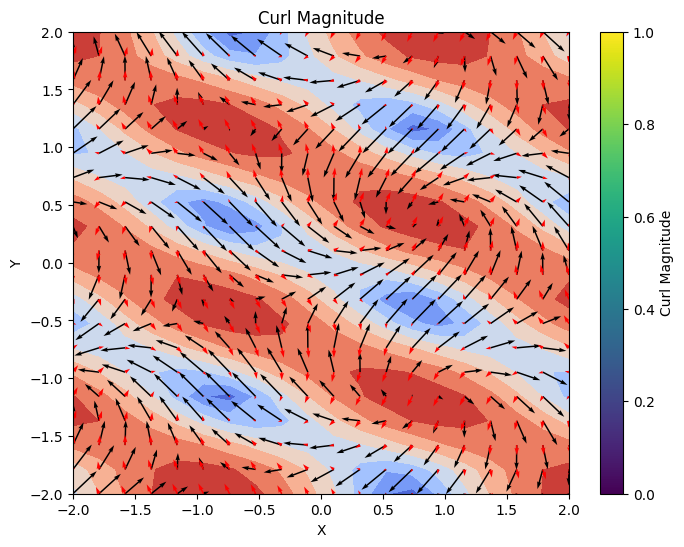

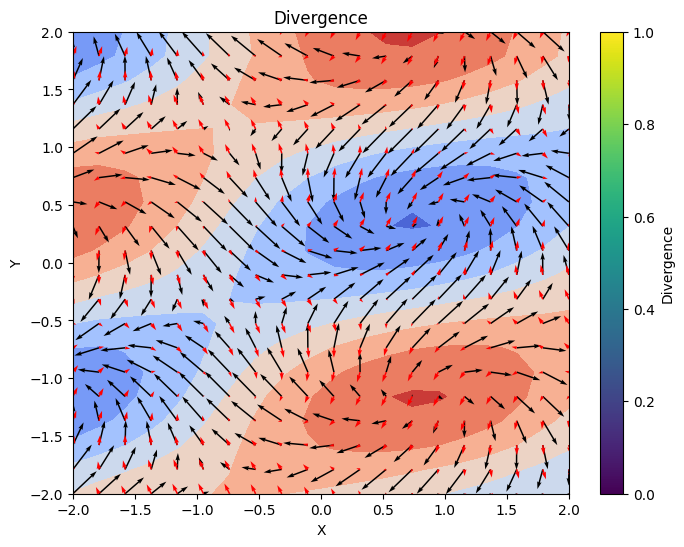

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# Define the vector field function
def vector_field(x, y):
    Fx = np.cos(x + 2 * y)
    Fy = np.sin(x - 2 * y)
    return Fx, Fy


# Define the curl of the vector field
def curl(x, y):
    curl_x = np.gradient(vector_field(x, y)[1], axis=1)
    curl_y = -np.gradient(vector_field(x, y)[0], axis=0)
    return curl_x, curl_y


# Define the divergence of the vector field
def divergence(x, y):
    div_x = np.gradient(vector_field(x, y)[0], axis=1)
    div_y = np.gradient(vector_field(x, y)[1], axis=0)
    return div_x + div_y


# Generate 2D grid for visualization
x = np.linspace(-2, 2, 20)
y = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x, y)

# Plot vector field
plt.figure(figsize=(8, 6))


# Plot curl magnitude
curl_x, curl_y = curl(X, Y)
curl_mag = np.sqrt(curl_x**2 + curl_y**2)

plt.contourf(X, Y, curl_mag, cmap="coolwarm")
plt.quiver(X, Y, np.cos(X + 2 * Y), np.sin(X - 2 * Y), scale=20)
plt.quiver(X, Y, curl_x, curl_y, color="red", scale=20)
plt.colorbar(label="Curl Magnitude")
plt.title("Curl Magnitude")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()


# Plot vector field
plt.figure(figsize=(8, 6))


div = divergence(X, Y)

plt.contourf(X, Y, div, cmap="coolwarm")
plt.quiver(X, Y, np.cos(X + 2 * Y), np.sin(X - 2 * Y), scale=20)
plt.quiver(X, Y, curl_x, curl_y, color="red", scale=20)
plt.colorbar(label="Divergence")
plt.title("Divergence")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()